<a href="https://colab.research.google.com/github/peppecappella/customer-churn-prediction-project/blob/main/2_Models_Training_and_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART II: Models training and comparison**

This second part is focused on modeling, evaluating, and comparing machine learning models, building upon the feature engineering efforts initiated in the first part. After setting up the working environment and installing all the necessary libraries, preliminary steps are taken, including encoding categorical variables, removing non-essential columns, addressing missing and infinite values, and splitting the dataset into training and test sets, thereby preparing for the modeling phase.

Immediately thereafter, a preprocessing phase is implemented using BetaGeoFitter to calculate the predicted_purchases variable. This inference is based on the values of recency, T, and frequency, which are processed separately on the training and test sets to prevent data leakage.

In the subsequent modeling phase, the models XGBoost, CatBoost, LightGBM, and a sequential neural network are trained, with particular attention paid to optimizing hyperparameters to enhance their performance. The models are assessed using standard metrics such as accuracy, confusion matrix, AUC, and other classification metrics. A direct comparison of the trained models is facilitated by the use of ROC and Lift charts, providing a clear view of which model performs better in predicting churn.

Finally, a detailed report on model performance is compiled using the kds library, enriched with an analysis of feature importance for the LightGBM model (the best performer), offering valuable insights into which attributes most significantly influence predictions. This process enables a deep understanding of the key drivers behind customer churn behavior, aiding in the development of targeted retention strategies.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas numpy matplotlib seaborn scipy scikit-learn mlxtend xgboost hyperopt lifetimes joblib kds optuna catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.7 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import math
import ast
from datetime import timedelta
import re
from scipy import stats
from sklearn.preprocessing import LabelEncoder

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Modeling
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, recall_score, precision_score
import xgboost as xgb
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from hyperopt.pyll.stochastic import sample

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import warnings
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, roc_auc_score

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifetimes import BetaGeoFitter
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score

import joblib
from joblib import dump

RANDOM_STATE = 42

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
df=pd.read_csv('drive/MyDrive/CHURN PREDICTION PROJECT/temp_data/labelled_set_with_features.csv')

In [6]:
df = df.drop(columns=['store_id','reference_date'])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.fillna(0, inplace=True)
df.fillna(0, inplace=True)

df = df[~df.isin([float('inf'), float('-inf')]).any(axis=1)]

In [7]:
df.head()

,customer_id,numero_prodotti_acquistati_totale,numero_prodotti_restituiti_totale,ordini_per_categoria,total_spent,avg_daily_spent,frequency,recency,T,monetary_value,CLTV,num_categories_acquistate,num_categories_restitute,prodotti_restituiti,prodotti_acquistati,return_rate,spesa_settimanale_media,variazione_media_spesa,frequenza_media_acquisti_settimanali,frequenza_media_acquisti_sconto_settimanali,num_visited_stores,churn,last_store_visited,visited_churn_store,favorite_store,loyatlty_status,changed_store,loyalty_score,age,sex,privacy_score,phone_provided_score,reachable_by_mail,reachable_by_email,reachable_by_phone
0,23,22.00,0.00,2.75,169.40,42.35,2.00,22.00,57.00,62.92,10044.04,8.00,0.00,0.00,22.00,0.00,42.35,70.50,5.50,2.00,1,1,49,1,49,1,1,3,44,2,1,1,True,True,True
1,30,12.00,0.00,4.00,10179.56,5089.78,1.00,42.00,49.00,10176.46,804753.68,3.00,0.00,0.00,12.00,0.00,5089.78,164086.50,6.00,6.00,1,1,49,1,49,1,1,4,44,2,1,0,True,True,False
2,30,12.00,0.00,4.00,10179.56,5089.78,1.00,42.00,138.00,10176.46,804753.68,3.00,0.00,0.00,12.00,0.00,5089.78,164086.50,6.00,6.00,1,1,49,1,49,1,1,4,44,2,1,0,True,True,False
3,48,3.00,0.00,3.00,232.50,232.50,0.00,0.00,77.00,0.00,18380.48,1.00,0.00,0.00,3.00,0.00,232.50,0.00,3.00,2.00,1,0,49,1,49,1,1,4,68,1,1,1,True,True,True
4,48,28.00,15.00,5.60,670.58,167.64,2.00,27.00,28.00,328.63,39759.95,5.00,2.00,15.00,28.00,53.57,223.53,-53.00,9.33,5.50,1,0,49,1,49,1,1,4,68,1,1,1,True,True,True


In [85]:
import pandas as pd

columns_to_encode = [
    "sex", "privacy_score", "phone_provided_score",
    "last_store_visited", "visited_churn_store",
    "favorite_store", "loyatlty_status",
    "changed_store", "loyalty_score",
    "churn"
]

for col in columns_to_encode:
    df[col] = pd.Categorical(df[col])

df.shape

(120641, 35)

In [84]:
df.head(10)

,customer_id,numero_prodotti_acquistati_totale,numero_prodotti_restituiti_totale,ordini_per_categoria,total_spent,avg_daily_spent,frequency,recency,T,monetary_value,CLTV,num_categories_acquistate,num_categories_restitute,prodotti_restituiti,prodotti_acquistati,return_rate,spesa_settimanale_media,variazione_media_spesa,frequenza_media_acquisti_settimanali,frequenza_media_acquisti_sconto_settimanali,num_visited_stores,churn,last_store_visited,visited_churn_store,favorite_store,loyatlty_status,changed_store,loyalty_score,age,sex,privacy_score,phone_provided_score,reachable_by_mail,reachable_by_email,reachable_by_phone
0,23,22.00,0.00,2.75,169.40,42.35,2.00,22.00,57.00,62.92,10044.04,8.00,0.00,0.00,22.00,0.00,42.35,70.50,5.50,2.00,1,1,49,1,49,1,1,3,44,2,1,1,True,True,True
1,30,12.00,0.00,4.00,10179.56,5089.78,1.00,42.00,49.00,10176.46,804753.68,3.00,0.00,0.00,12.00,0.00,5089.78,164086.50,6.00,6.00,1,1,49,1,49,1,1,4,44,2,1,0,True,True,False
2,30,12.00,0.00,4.00,10179.56,5089.78,1.00,42.00,138.00,10176.46,804753.68,3.00,0.00,0.00,12.00,0.00,5089.78,164086.50,6.00,6.00,1,1,49,1,49,1,1,4,44,2,1,0,True,True,False
3,48,3.00,0.00,3.00,232.50,232.50,0.00,0.00,77.00,0.00,18380.48,1.00,0.00,0.00,3.00,0.00,232.50,0.00,3.00,2.00,1,0,49,1,49,1,1,4,68,1,1,1,True,True,True
4,48,28.00,15.00,5.60,670.58,167.64,2.00,27.00,28.00,328.63,39759.95,5.00,2.00,15.00,28.00,53.57,223.53,-53.00,9.33,5.50,1,0,49,1,49,1,1,4,68,1,1,1,True,True,True
5,48,3.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3.00,0.00,232.50,0.00,3.00,2.00,1,0,49,1,49,1,1,4,68,1,1,1,True,True,True
6,50,4.00,0.00,1.00,28.75,14.37,0.00,0.00,7.00,0.00,1136.43,4.00,0.00,0.00,4.00,0.00,14.37,-20.50,2.00,2.00,1,1,49,1,49,1,1,4,43,2,1,1,True,True,True
7,60,1.00,0.00,1.00,49.98,49.98,0.00,0.00,43.00,0.00,3951.21,1.00,0.00,0.00,1.00,0.00,49.98,0.00,1.00,0.00,1,1,49,1,1,1,1,3,47,1,1,1,True,True,True
8,76,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,2.00,0.00,4.75,0.00,2.00,0.00,1,1,9,1,9,1,1,3,37,1,1,1,True,True,True
9,76,1.00,0.00,1.00,9.85,9.85,0.00,0.00,74.00,0.00,778.70,1.00,0.00,0.00,1.00,0.00,9.85,0.00,1.00,0.00,1,0,9,1,9,1,1,3,37,1,1,1,True,True,True


In [10]:
# Pre-processing and splitting the DataFrame
y = df['churn']
X = df.drop(columns=['churn'])  # Keep 'customer_id' until after the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

# Now, separate 'customer_id' from the test set
test_ids = X_test['customer_id']
X_train = X_train.drop(columns=['customer_id'])
X_test = X_test.drop(columns=['customer_id'])

In [11]:
from lifetimes import BetaGeoFitter

# Addestramento di BetaGeoFitter sul set di addestramento
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(X_train['frequency'], X_train['recency'], X_train['T'])
t = 90

# Calcolo di predicted_purchases per il set di addestramento
X_train['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, X_train['frequency'], X_train['recency'], X_train['T'])

# Calcolo di predicted_purchases per il set di test
X_test['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, X_test['frequency'], X_test['recency'], X_test['T'])

In [12]:
# Seleziona le colonne numeriche
num_columns = X_train.select_dtypes(include=['int64', 'float64']).columns



In [13]:
# Applica fillna(0) solo alle colonne numeriche
X_train[num_columns] = X_train[num_columns].fillna(0)
X_test[num_columns] = X_test[num_columns].fillna(0)

## Xgboost Hyperparameter optimization (optimizing auc)

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Definizione della funzione obiettivo per Optuna con AUC
def objective(trial):
    # Definizione degli iperparametri da ottimizzare
    params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.1]),
        'n_estimators': trial.suggest_categorical('n_estimators',[100,300,500]),
        'max_depth': trial.suggest_categorical('max_depth', [1, 3, 5, 7, 9]),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    # Creazione del modello con i parametri correnti
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss',enable_categorical=True)

    # Addestramento del modello
    model.fit(X_train, y_train)

    # Predizione della probabilità sui dati di test
    preds = model.predict_proba(X_test)[:, 1]

    # Calcolo dell'AUC
    auc = roc_auc_score(y_test, preds)

    # Restituzione dell'AUC, in modo da massimizzarlo
    return auc

# Creazione di uno studio Optuna per massimizzare l'AUC
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Stampa dei risultati
print('Numero di trial completati:', len(study.trials))
print('Miglior trial:', study.best_trial.params)

# Addestramento del modello con i migliori iperparametri trovati
best_params = study.best_trial.params
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss',enable_categorical=True)
final_model.fit(X_train, y_train)

# Predizione e valutazione con i migliori parametri
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]
print("AUC finale:", roc_auc_score(y_test, y_pred_proba_final))

## Xgboost Classifier (Holdout validation)

In [14]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


params = {'lambda': 0.2620577593593147, 'alpha': 0.05222547404999533, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 1,
          'enable_categorical': True,
          'random_state': 42
         }


xgb_model = xgb.XGBClassifier(**params)


xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
print("AUC:", auc)

Accuracy: 0.7199635293630071
Confusion Matrix:
 [[9331 3525]
 [3232 8041]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73     12856
           1       0.70      0.71      0.70     11273

    accuracy                           0.72     24129
   macro avg       0.72      0.72      0.72     24129
weighted avg       0.72      0.72      0.72     24129

AUC: 0.7939614611317216


In [15]:
import kds

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

## Catboost Hyperparameter optimization (optimizing auc)

In [ ]:
import optuna
import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


def objective(trial):

    params = {
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.1]),
        'depth': trial.suggest_int('depth', 1, 10),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'iterations': trial.suggest_categorical('iterations', [100, 300, 500]),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.0),
        'random_seed': 42,
    }


    model = cb.CatBoostClassifier(**params, eval_metric='AUC', silent=True,
                                  cat_features=['last_store_visited', 'visited_churn_store',
                                                'favorite_store', 'loyatlty_status', 'changed_store',
                                                'loyalty_score', 'sex', 'privacy_score', 'phone_provided_score',
                                                'reachable_by_mail', 'reachable_by_email', 'reachable_by_phone'],
                                  auto_class_weights='Balanced')


    model.fit(X_train, y_train, verbose=False)


    preds = model.predict_proba(X_test)[:, 1]


    auc = roc_auc_score(y_test, preds)


    return auc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


print('Numero di trial completati:', len(study.trials))
print('Miglior trial:', study.best_trial.params)


best_params = study.best_trial.params
final_model = cb.CatBoostClassifier(**best_params, eval_metric='AUC', silent=True,
                                    cat_features=['last_store_visited', 'visited_churn_store',
                                                  'favorite_store', 'loyatlty_status', 'changed_store',
                                                  'loyalty_score', 'sex', 'privacy_score', 'phone_provided_score',
                                                  'reachable_by_mail', 'reachable_by_email', 'reachable_by_phone'],
                                    auto_class_weights='Balanced')
final_model.fit(X_train, y_train, verbose=False)


y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]
print("AUC finale:", roc_auc_score(y_test, y_pred_proba_final))

# Catboost hold-out validation

Numero di trial completati: 100
Miglior trial: {'l2_leaf_reg': 0.004134830088690625, 'learning_rate': 0.1, 'depth': 10, 'border_count': 66, 'iterations': 500, 'random_strength': 16, 'bagging_temperature': 3.5441078676831976}

In [16]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score



params = {'l2_leaf_reg': 0.004134830088690625, 'learning_rate': 0.1, 'depth': 10, 'border_count': 66, 'iterations': 500, 'random_strength': 16, 'bagging_temperature': 3.5441078676831976}


cat_features = ['last_store_visited', 'visited_churn_store',
                'favorite_store', 'loyatlty_status', 'changed_store',
                'loyalty_score', 'sex', 'privacy_score', 'phone_provided_score',
                'reachable_by_mail', 'reachable_by_email', 'reachable_by_phone']


cb_model = CatBoostClassifier(**params, cat_features=cat_features, verbose=0)  # `verbose=0` per ridurre l'output durante l'addestramento


cb_model.fit(X_train, y_train)


y_pred = cb_model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, cb_model.predict_proba(X_test)[:, 1])
print("AUC:", auc)


Accuracy: 0.6960089518836255
Confusion Matrix:
 [[8946 3910]
 [3425 7848]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71     12856
           1       0.67      0.70      0.68     11273

    accuracy                           0.70     24129
   macro avg       0.70      0.70      0.70     24129
weighted avg       0.70      0.70      0.70     24129

AUC: 0.762837758617368


In [17]:
import kds

y_prob_catb = cb_model.predict_proba(X_test)[:, 1]

# lightgbm hyperparameter optimization

In [18]:
y_train = y_train.cat.codes
y_test = y_test.cat.codes

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

cat_features = ['last_store_visited', 'visited_churn_store',
                'favorite_store', 'loyatlty_status', 'changed_store',
                'loyalty_score', 'sex', 'privacy_score', 'phone_provided_score',
                'reachable_by_mail', 'reachable_by_email', 'reachable_by_phone']

'''for feature in cat_features:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')'''


def objective(trial):
    params = {
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'max_depth': trial.suggest_int('max_depth', -1, 16),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000]),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'metric': 'auc',
        'objective': 'binary',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    gbm = lgb.train(params, dtrain, valid_sets=[dtrain])
    preds = gbm.predict(X_test)
    auc = roc_auc_score(y_test, preds)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Numero di trial completati:', len(study.trials))
print('Miglior trial:', study.best_trial.params)

best_params = study.best_trial.params
final_gbm = lgb.LGBMClassifier(**best_params)
final_gbm.fit(X_train, y_train)

y_pred_proba_final = final_gbm.predict_proba(X_test)[:, 1]
print("AUC finale:", roc_auc_score(y_test, y_pred_proba_final))

# Lightgbm holdout validation

In [20]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder


cat_features = [
    'last_store_visited', 'visited_churn_store', 'favorite_store',
    'loyatlty_status', 'changed_store', 'loyalty_score', 'sex',
    'privacy_score', 'phone_provided_score', 'reachable_by_mail',
    'reachable_by_email', 'reachable_by_phone'
]

params = {'reg_alpha': 0.008839705012734247, 'reg_lambda': 0.0051221971830796185, 'num_leaves': 251, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 1000, 'min_child_samples': 5, 'min_child_weight': 0.080825579399429, 'subsample': 0.5321039667031278, 'colsample_bytree': 0.9493022659213282}



gbm = lgb.LGBMClassifier(**params)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc')


y_prob_lgbm = gbm.predict_proba(X_test)[:, 1]


y_pred_lgbm = np.where(y_prob_lgbm >= 0.5, 1, 0)


print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("AUC:", roc_auc_score(y_test, y_prob_lgbm))


feature_importances = gbm.feature_importances_


feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

[LightGBM] [Info] Number of positive: 45092, number of negative: 51420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3621
[LightGBM] [Info] Number of data points in the train set: 96512, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467217 -> initscore=-0.131322
[LightGBM] [Info] Start training from score -0.131322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

### OneHotEncoding

In [22]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

categorical_cols = X_train.select_dtypes(include=['category']).columns

X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

X_train_encoded_df = pd.DataFrame(X_train_encoded, index=X_train.index, columns=encoder.get_feature_names_out(categorical_cols))
X_test_encoded_df = pd.DataFrame(X_test_encoded, index=X_test.index, columns=encoder.get_feature_names_out(categorical_cols))

X_train_prepared = pd.concat([X_train.drop(categorical_cols, axis=1), X_train_encoded_df], axis=1)
X_test_prepared = pd.concat([X_test.drop(categorical_cols, axis=1), X_test_encoded_df], axis=1)

X_train=X_train_prepared.copy()
X_test=X_test_prepared.copy()


In [23]:
X_train.shape

(96512, 137)

### Standardizzazione

In [24]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

### SEQUENTIAL NEURAL NETWORK

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, GaussianNoise
from keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from keras.callbacks import EarlyStopping


model = Sequential([
    GaussianNoise(0.01, input_shape=(X_train.shape[1],)),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])


early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True, verbose=1)


history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


y_pred = (model.predict(X_test) > 0.5).astype(int)


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC (Scikit-Learn):", roc_auc_score(y_test, model.predict(X_test)))


Epoch 1/200
754/754 [==============================] - 12s 13ms/step - loss: 0.6826 - accuracy: 0.5813 - auc: 0.6121 - val_loss: 0.6378 - val_accuracy: 0.6205 - val_auc: 0.6800
Epoch 2/200
754/754 [==============================] - 9s 12ms/step - loss: 0.6419 - accuracy: 0.6240 - auc: 0.6732 - val_loss: 0.6320 - val_accuracy: 0.6310 - val_auc: 0.6871
Epoch 3/200
754/754 [==============================] - 9s 12ms/step - loss: 0.6351 - accuracy: 0.6304 - auc: 0.6824 - val_loss: 0.6305 - val_accuracy: 0.6332 - val_auc: 0.6898
Epoch 4/200
754/754 [==============================] - 10s 13ms/step - loss: 0.6326 - accuracy: 0.6337 - auc: 0.6879 - val_loss: 0.6287 - val_accuracy: 0.6361 - val_auc: 0.6930
Epoch 5/200
754/754 [==============================] - 10s 13ms/step - loss: 0.6300 - accuracy: 0.6381 - auc: 0.6927 - val_loss: 0.6274 - val_accuracy: 0.6407 - val_auc: 0.6962
Epoch 6/200
754/754 [==============================] - 11s 14ms/step - loss: 0.6275 - accuracy: 0.6443 - auc: 0.6971 

In [30]:
import kds

y_prob_SNN = model.predict(X_test)

755/755 [==============================] - 3s 4ms/step


# **MODELS AUC PERFORMANCE COMPARISON**

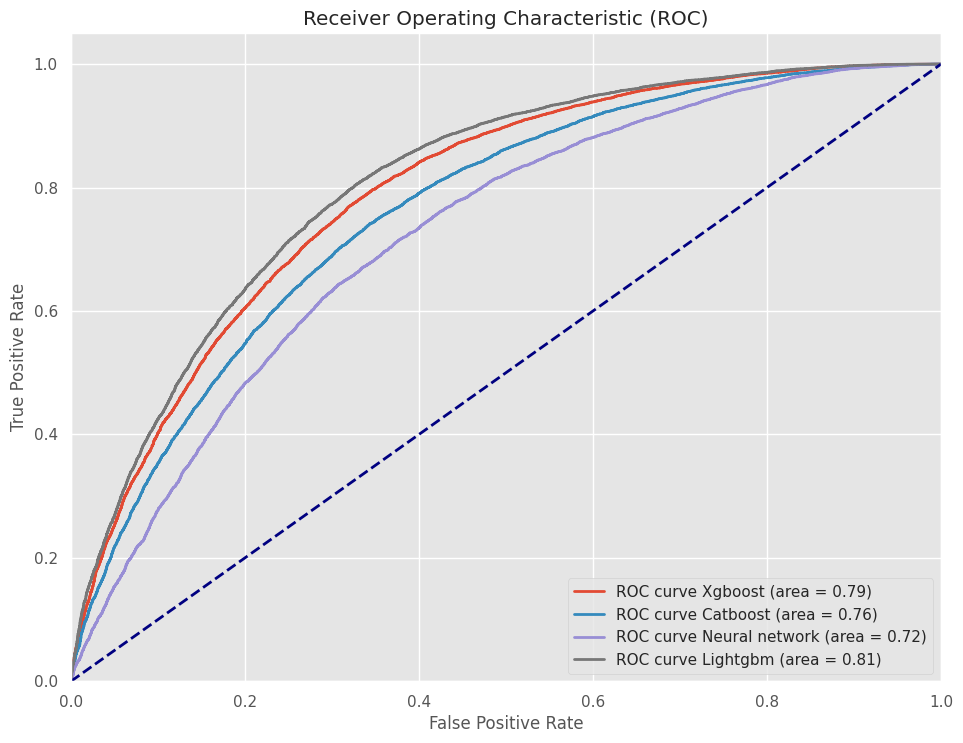

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import kds


plt.figure(figsize=(10, 8))

for model_name, y_prob in [('Xgboost', y_prob_xgb),
                           ('Catboost', y_prob_catb),
                           ('Neural network', y_prob_SNN),
                           ('Lightgbm', y_prob_lgbm)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve {model_name} (area = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.savefig('drive/MyDrive/CHURN PREDICTION PROJECT/models_auc_comparison.png', dpi=90, bbox_inches='tight')

plt.show()

# **MODELS LIFT PERFORMANCE COMPARISON**

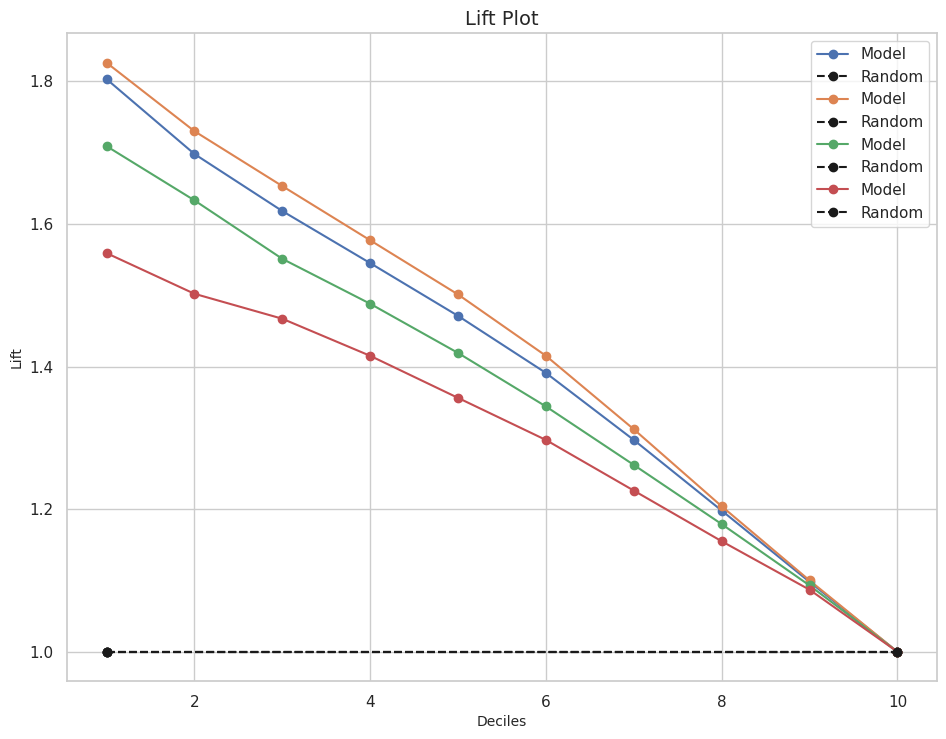

In [57]:
import matplotlib.pyplot as plt
import kds

plt.figure(figsize=(10, 8))


kds.metrics.plot_lift(y_test, y_prob_xgb)
kds.metrics.plot_lift(y_test, y_prob_lgbm)
kds.metrics.plot_lift(y_test, y_prob_catb)
kds.metrics.plot_lift(y_test, y_prob_SNN )


plt.savefig('drive/MyDrive/CHURN PREDICTION PROJECT/models_lift_comparison.png', dpi=90, bbox_inches='tight')


plt.show()

# **# LIGHTGBM PERFORMANCE METRICS**

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.89,1.00,0.94,2413.00,2058.00,355.00,1127.30,2413,85.29,2413.00,2058.00,2413,355.00,10.00,18.26,21.41,2.76,15.49,1.83
1,2,0.80,0.89,0.85,2413.00,1842.00,571.00,1127.30,2413,76.34,4826.00,3900.00,4826,926.00,20.00,34.60,42.81,7.20,27.39,1.73
2,3,0.70,0.80,0.75,2413.00,1690.00,723.00,1127.30,2413,70.04,7239.00,5590.00,7239,1649.00,30.00,49.59,64.22,12.83,36.76,1.65
3,4,0.60,0.70,0.65,2413.00,1521.00,892.00,1127.30,2413,63.03,9652.00,7111.00,9652,2541.00,40.00,63.08,85.62,19.77,43.31,1.58
4,5,0.47,0.60,0.54,2413.00,1350.00,1063.00,1127.30,1621,55.95,12065.00,8461.00,11273,3604.00,50.00,75.06,100.00,28.03,47.02,1.50
5,6,0.32,0.47,0.40,2413.00,1112.00,1301.00,1127.30,0,46.08,14478.00,9573.00,11273,4905.00,60.00,84.92,100.00,38.15,46.77,1.42
6,7,0.17,0.32,0.24,2413.00,783.00,1630.00,1127.30,0,32.45,16891.00,10356.00,11273,6535.00,70.00,91.87,100.00,50.83,41.03,1.31
7,8,0.07,0.17,0.11,2413.00,499.00,1914.00,1127.30,0,20.68,19304.00,10855.00,11273,8449.00,80.00,96.29,100.00,65.72,30.57,1.20
8,9,0.01,0.07,0.04,2413.00,308.00,2105.00,1127.30,0,12.76,21717.00,11163.00,11273,10554.00,90.00,99.02,100.00,82.09,16.93,1.10
9,10,0.00,0.01,0.01,2412.00,110.00,2302.00,1127.30,0,4.56,24129.00,11273.00,11273,12856.00,100.00,100.00,100.00,100.00,0.00,1.00


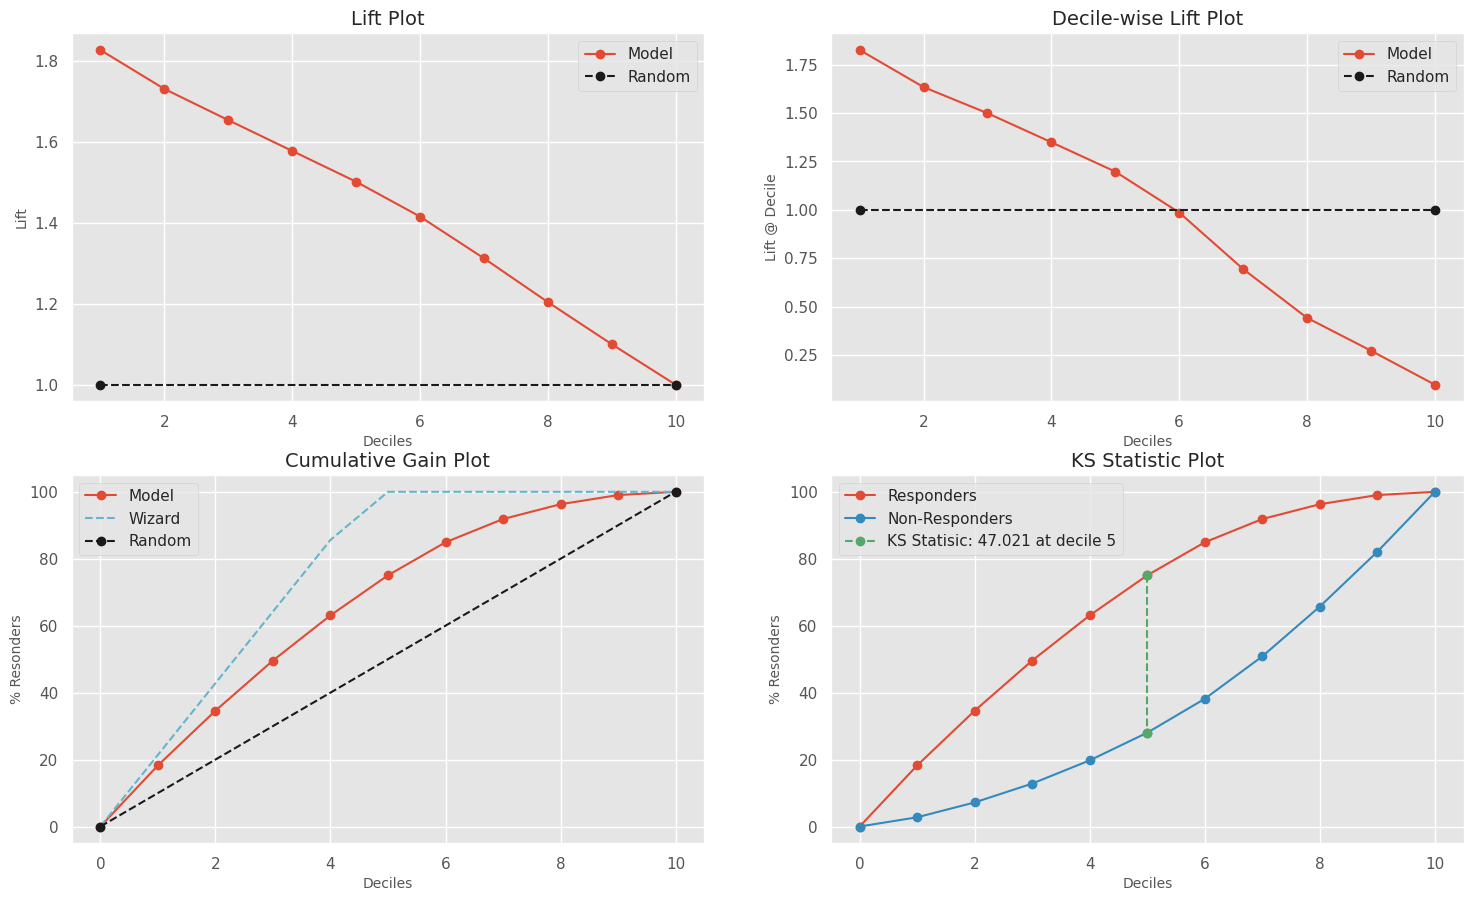

In [82]:
import matplotlib.pyplot as plt

kds.metrics.report(y_test, y_prob_lgbm, plot_style='ggplot')

# **# XGBOOST PERFORMANCE METRICS**

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.84,1.00,0.90,2413.00,2033.00,380.00,1127.30,2413,84.25,2413.00,2033.00,2413,380.00,10.00,18.03,21.41,2.96,15.08,1.80
1,2,0.75,0.84,0.80,2413.00,1796.00,617.00,1127.30,2413,74.43,4826.00,3829.00,4826,997.00,20.00,33.97,42.81,7.75,26.21,1.70
2,3,0.67,0.75,0.71,2413.00,1643.00,770.00,1127.30,2413,68.09,7239.00,5472.00,7239,1767.00,30.00,48.54,64.22,13.74,34.80,1.62
3,4,0.58,0.67,0.62,2413.00,1495.00,918.00,1127.30,2413,61.96,9652.00,6967.00,9652,2685.00,40.00,61.80,85.62,20.89,40.92,1.54
4,5,0.48,0.58,0.53,2413.00,1326.00,1087.00,1127.30,1621,54.95,12065.00,8293.00,11273,3772.00,50.00,73.56,100.00,29.34,44.23,1.47
5,6,0.36,0.48,0.42,2413.00,1117.00,1296.00,1127.30,0,46.29,14478.00,9410.00,11273,5068.00,60.00,83.47,100.00,39.42,44.05,1.39
6,7,0.25,0.36,0.30,2413.00,822.00,1591.00,1127.30,0,34.06,16891.00,10232.00,11273,6659.00,70.00,90.77,100.00,51.80,38.97,1.30
7,8,0.14,0.25,0.19,2413.00,571.00,1842.00,1127.30,0,23.66,19304.00,10803.00,11273,8501.00,80.00,95.83,100.00,66.12,29.71,1.20
8,9,0.05,0.14,0.09,2413.00,337.00,2076.00,1127.30,0,13.97,21717.00,11140.00,11273,10577.00,90.00,98.82,100.00,82.27,16.55,1.10
9,10,0.00,0.05,0.02,2412.00,133.00,2279.00,1127.30,0,5.51,24129.00,11273.00,11273,12856.00,100.00,100.00,100.00,100.00,0.00,1.00


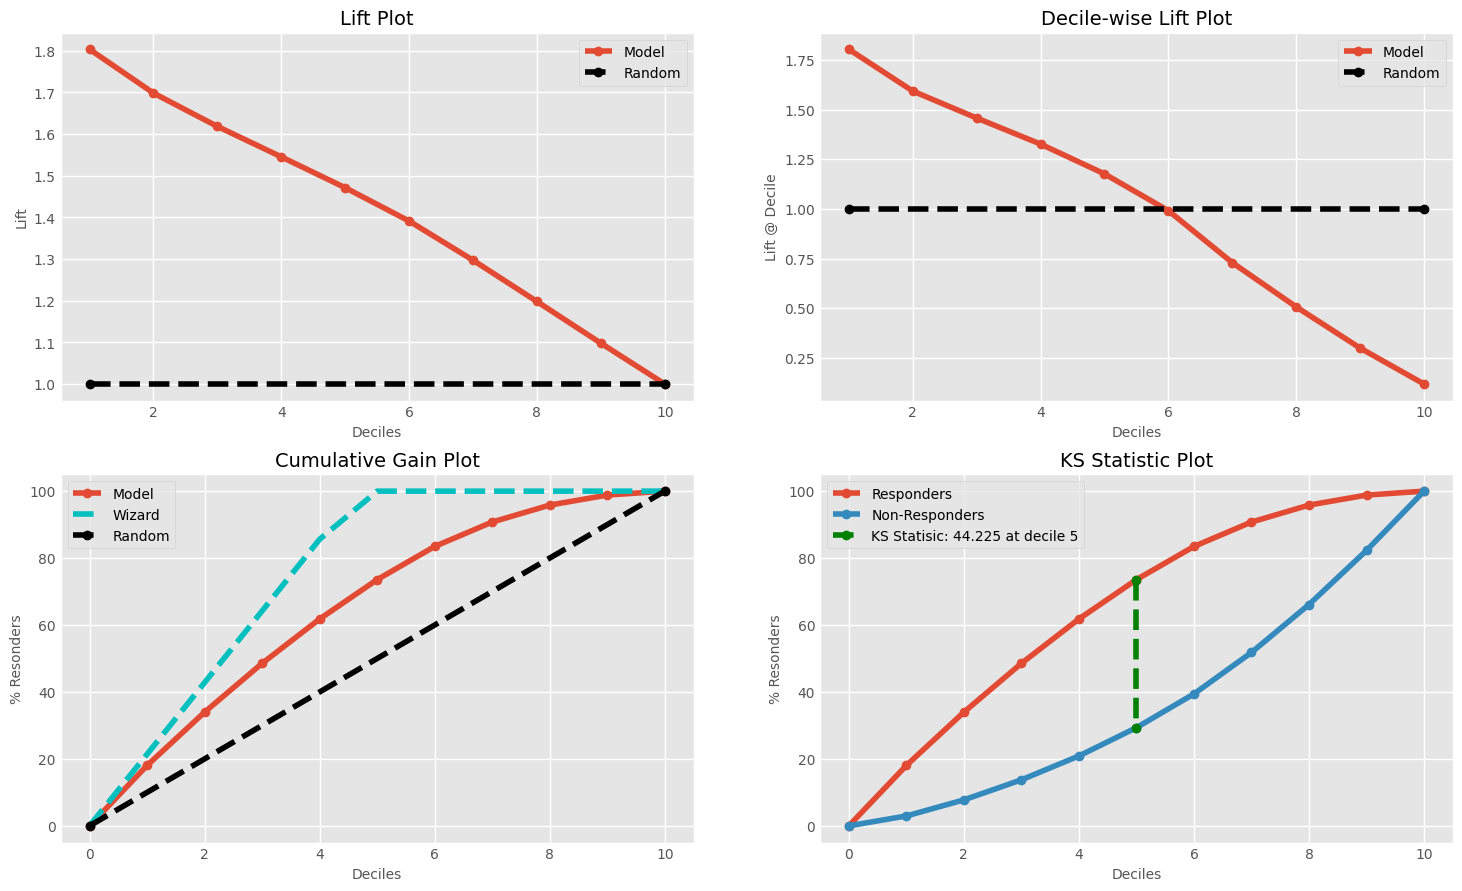

In [39]:
kds.metrics.report(y_test,y_prob_xgb,plot_style='ggplot')

# **# CATBOOST PERFORMANCE METRICS**

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.77,1.00,0.85,2413.00,1926.00,487.00,1127.30,2413,79.82,2413.00,1926.00,2413,487.00,10.00,17.09,21.41,3.79,13.30,1.71
1,2,0.70,0.77,0.73,2413.00,1755.00,658.00,1127.30,2413,72.73,4826.00,3681.00,4826,1145.00,20.00,32.65,42.81,8.91,23.75,1.63
2,3,0.64,0.70,0.67,2413.00,1566.00,847.00,1127.30,2413,64.90,7239.00,5247.00,7239,1992.00,30.00,46.55,64.22,15.49,31.05,1.55
3,4,0.57,0.64,0.60,2413.00,1463.00,950.00,1127.30,2413,60.63,9652.00,6710.00,9652,2942.00,40.00,59.52,85.62,22.88,36.64,1.49
4,5,0.49,0.57,0.53,2413.00,1286.00,1127.00,1127.30,1621,53.30,12065.00,7996.00,11273,4069.00,50.00,70.93,100.00,31.65,39.28,1.42
5,6,0.40,0.49,0.45,2413.00,1098.00,1315.00,1127.30,0,45.50,14478.00,9094.00,11273,5384.00,60.00,80.67,100.00,41.88,38.79,1.34
6,7,0.30,0.40,0.35,2413.00,865.00,1548.00,1127.30,0,35.85,16891.00,9959.00,11273,6932.00,70.00,88.34,100.00,53.92,34.42,1.26
7,8,0.19,0.30,0.24,2413.00,675.00,1738.00,1127.30,0,27.97,19304.00,10634.00,11273,8670.00,80.00,94.33,100.00,67.44,26.89,1.18
8,9,0.08,0.19,0.13,2413.00,454.00,1959.00,1127.30,0,18.82,21717.00,11088.00,11273,10629.00,90.00,98.36,100.00,82.68,15.68,1.09
9,10,0.00,0.08,0.03,2412.00,185.00,2227.00,1127.30,0,7.67,24129.00,11273.00,11273,12856.00,100.00,100.00,100.00,100.00,0.00,1.00


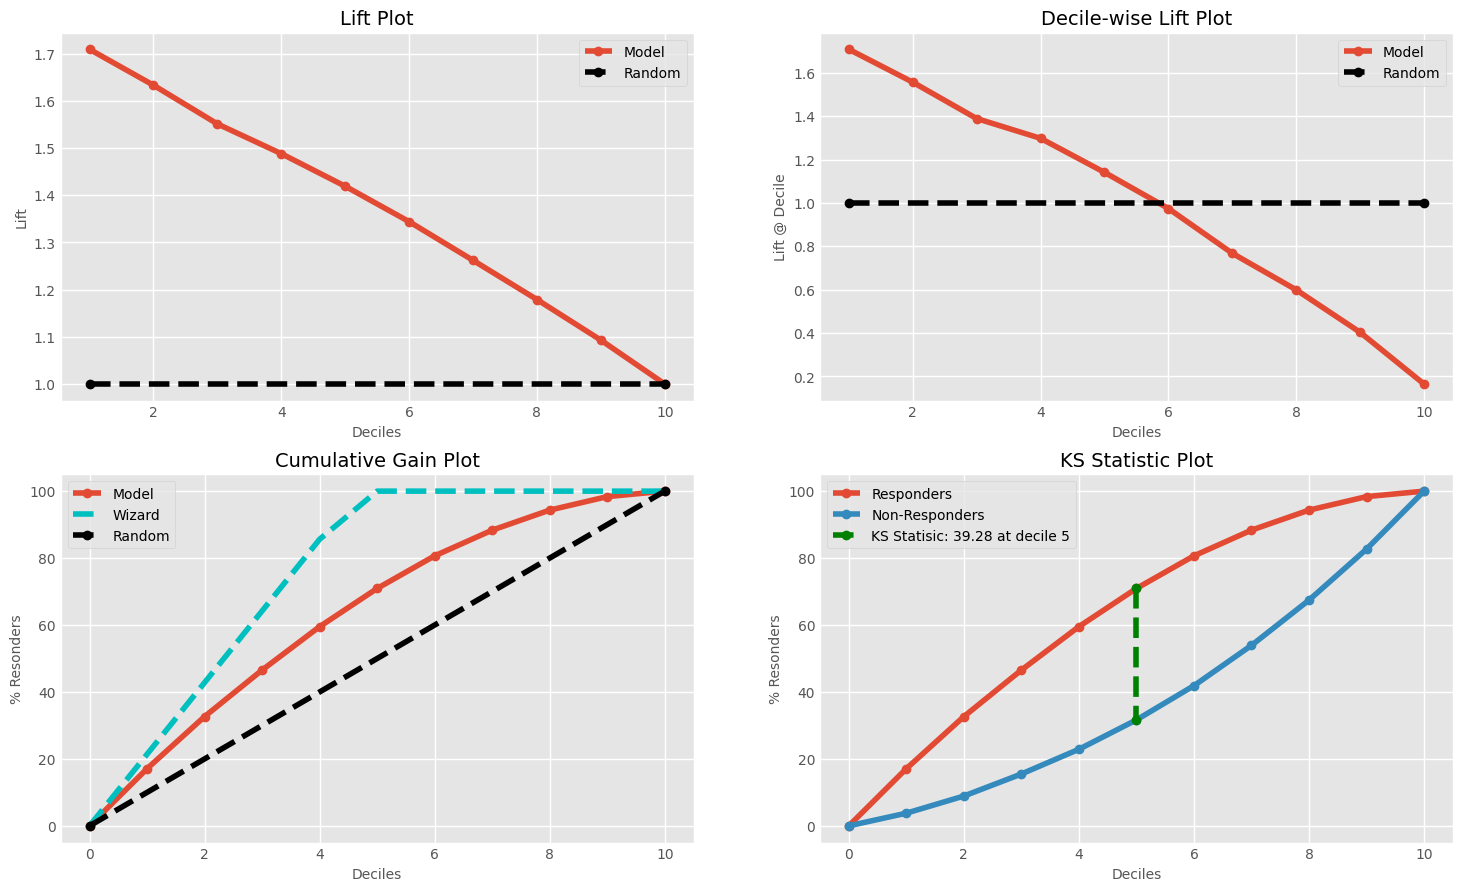

In [37]:
kds.metrics.report(y_test,y_prob_catb,plot_style='ggplot')

#**NEURAL NETWORK PERFORMANCE METRICS**#

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.69,0.91,0.74,2413.00,1757.00,656.00,1127.30,2413,72.81,2413.00,1757.00,2413,656.00,10.00,15.59,21.41,5.10,10.48,1.56
1,2,0.65,0.69,0.67,2413.00,1629.00,784.00,1127.30,2413,67.51,4826.00,3386.00,4826,1440.00,20.00,30.04,42.81,11.20,18.84,1.50
2,3,0.62,0.65,0.64,2413.00,1576.00,837.00,1127.30,2413,65.31,7239.00,4962.00,7239,2277.00,30.00,44.02,64.22,17.71,26.30,1.47
3,4,0.58,0.62,0.60,2413.00,1421.00,992.00,1127.30,2413,58.89,9652.00,6383.00,9652,3269.00,40.00,56.62,85.62,25.43,31.19,1.42
4,5,0.50,0.58,0.54,2413.00,1259.00,1154.00,1127.30,1621,52.18,12065.00,7642.00,11273,4423.00,50.00,67.79,100.00,34.40,33.39,1.36
5,6,0.42,0.50,0.46,2413.00,1128.00,1285.00,1127.30,0,46.75,14478.00,8770.00,11273,5708.00,60.00,77.80,100.00,44.40,33.40,1.30
6,7,0.35,0.42,0.39,2413.00,905.00,1508.00,1127.30,0,37.51,16891.00,9675.00,11273,7216.00,70.00,85.83,100.00,56.13,29.70,1.23
7,8,0.29,0.35,0.32,2413.00,740.00,1673.00,1127.30,0,30.67,19304.00,10415.00,11273,8889.00,80.00,92.39,100.00,69.14,23.25,1.16
8,9,0.19,0.29,0.25,2413.00,616.00,1797.00,1127.30,0,25.53,21717.00,11031.00,11273,10686.00,90.00,97.85,100.00,83.12,14.73,1.09
9,10,0.00,0.19,0.10,2412.00,242.00,2170.00,1127.30,0,10.03,24129.00,11273.00,11273,12856.00,100.00,100.00,100.00,100.00,0.00,1.00


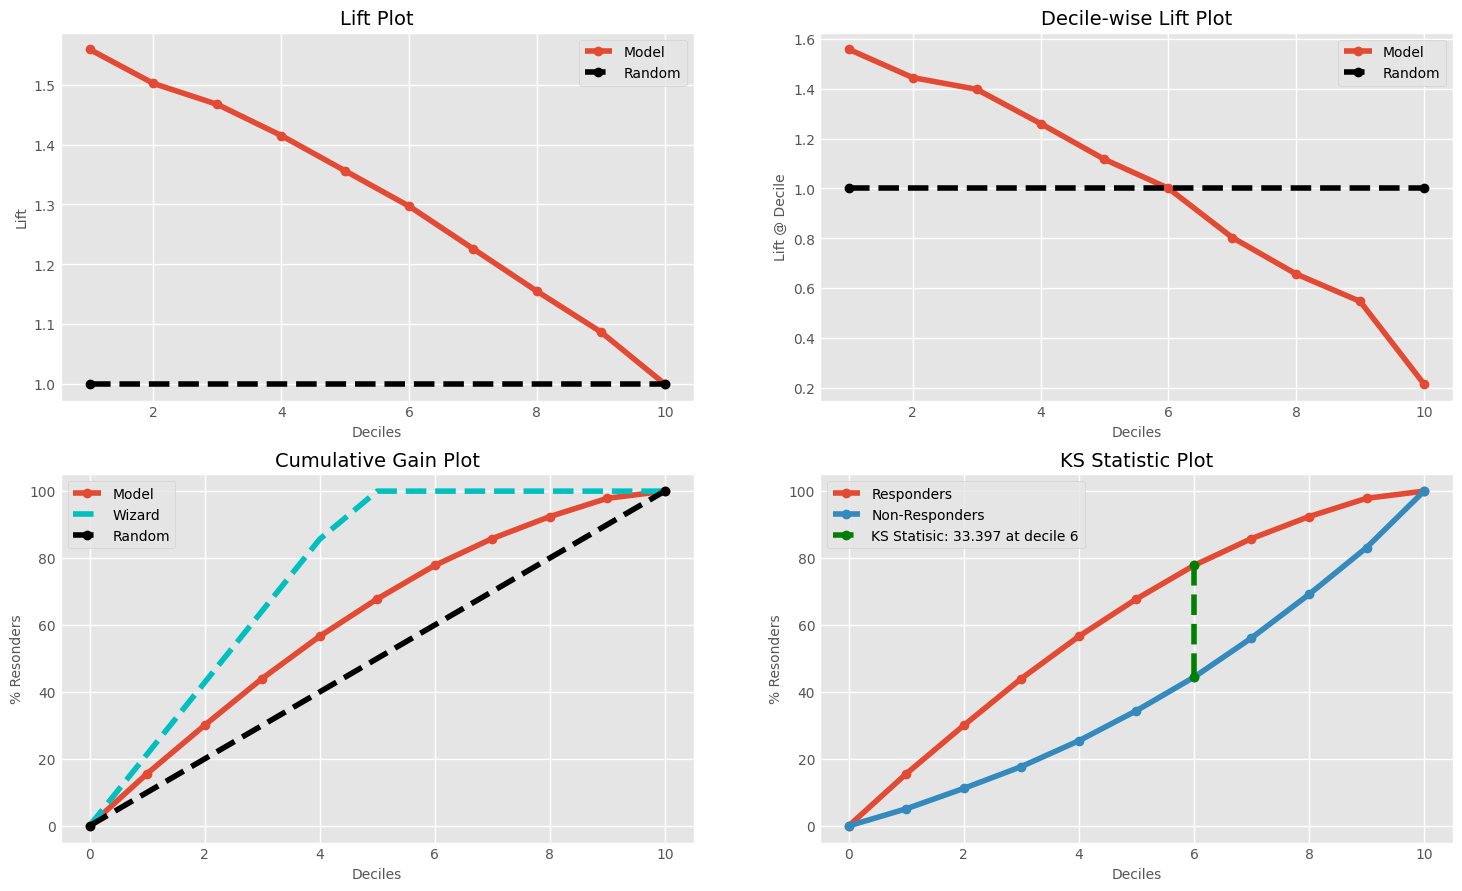

In [38]:
kds.metrics.report(y_test,y_prob_SNN,plot_style='ggplot')

# **LIGHTGBM FEATURES IMPORTANCE**

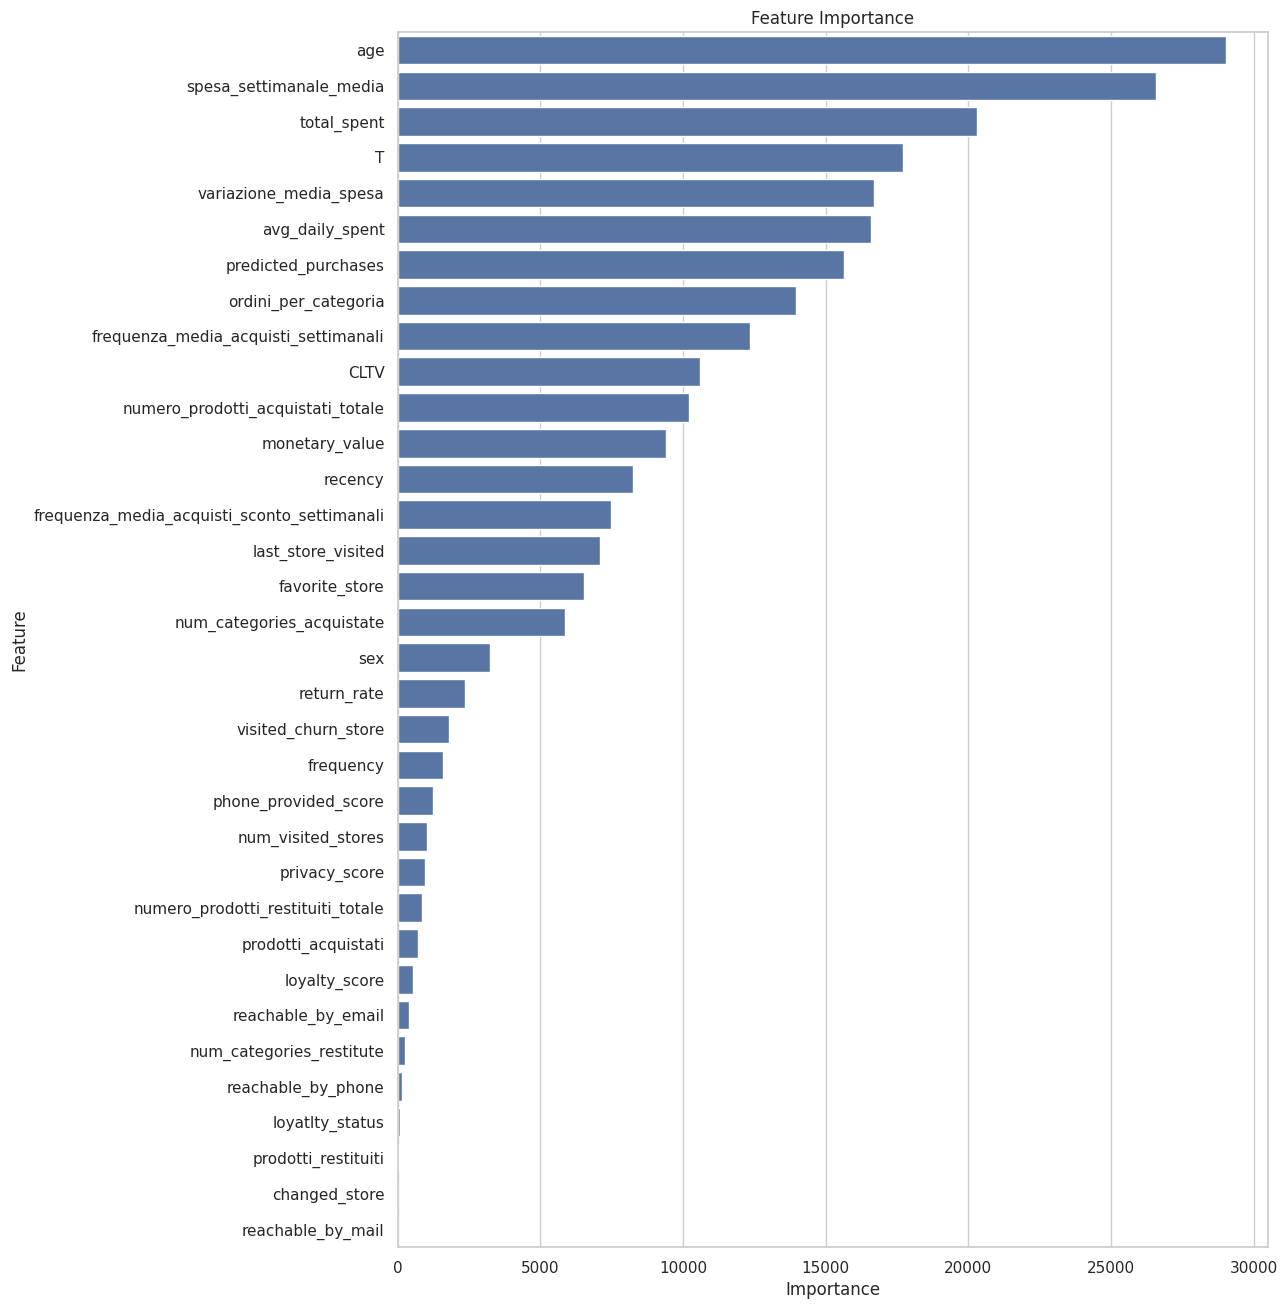

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")


plt.figure(figsize=(10, 15))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)

plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')


plt.show()
